In [ ]:
# @title

%tensorflow_version
import tensorflow as tf
print(tf.__version__)

Colab only includes TensorFlow 2.x; %tensorflow_version has no effect.
2.15.0


In [ ]:
#ref - https://stackoverflow.com/questions/14463277/how-to-disable-python-warnings

# Basic Libs..
import warnings
warnings.filterwarnings("ignore")
import math
import pandas as pd
import numpy as np
import scipy
import scipy.sparse
from tqdm import tqdm,tqdm_notebook
from prettytable import PrettyTable
import pickle
from IPython.display import Image
import os
print('CWD is ',os.getcwd())

# Vis Libs..
import seaborn as sns
import matplotlib.pyplot as plt
from wordcloud import WordCloud

# Text Libs..
import re
from gensim import corpora, models
import gensim
from gensim.utils import simple_preprocess
from gensim.parsing.preprocessing import STOPWORDS
from nltk.stem import WordNetLemmatizer, SnowballStemmer,PorterStemmer
from nltk.stem.porter import *
import nltk
from nltk.sentiment.vader import SentimentIntensityAnalyzer
from sklearn.feature_extraction.text import CountVectorizer,TfidfVectorizer
from sklearn.preprocessing import LabelBinarizer

# ML Libs...
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.linear_model import Ridge
from sklearn.metrics import mean_squared_error
import lightgbm as lgb
from sklearn.feature_selection import SelectKBest,f_regression
from sklearn.model_selection import GridSearchCV

# DL Libs..
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.layers import Dense, Input , Dropout, Flatten,concatenate,LSTM
from tensorflow.keras.layers import Embedding
import tensorflow.keras
from tensorflow.keras.models import Model,load_model
from tensorflow.keras.layers import BatchNormalization
from tensorflow.keras.utils import plot_model
from tensorflow.keras.callbacks import ModelCheckpoint,TensorBoard,ReduceLROnPlateau, EarlyStopping
from tensorflow.keras import backend as K

# Colab Libs...
from pydrive.auth import GoogleAuth
from pydrive.drive import GoogleDrive
from google.colab import auth
from oauth2client.client import GoogleCredentials

CWD is  /content


# 11. Baseline LSTM

**Set up Colab Environment**

In [ ]:
auth.authenticate_user()
gauth = GoogleAuth()
gauth.credentials = GoogleCredentials.get_application_default()
drive = GoogleDrive(gauth)

In [ ]:
from google.colab import drive
drive.mount('/content/gdrive')

Mounted at /content/gdrive


In [ ]:
import os
os.chdir('/content/gdrive/MyDrive/Mercari Price Prediction')
print("We are currently in the folder of ", os.getcwd())

We are currently in the folder of  /content/gdrive/MyDrive/Mercari Price Prediction


## 11.2. Load Data From GDrive

In [ ]:
# /content/gdrive/MyDrive/Mercari Price Prediction
file = open('/content/gdrive/MyDrive/Mercari Price Prediction/2. Processing/storage/df_train_model', 'rb')
df_train_model = pickle.load(file)
file.close()

file = open('/content/gdrive/MyDrive/Mercari Price Prediction/2. Processing/storage/df_test_model', 'rb')
df_test_model = pickle.load(file)
file.close()

print(df_train_model.shape,'\n',df_test_model.shape)

(1111901, 8) 
 (370634, 8)


## 11.3. Encoding Text Data - 'Item Name, Item Description'

In [ ]:
'''
Code for Text Cleaning & Preprocessing
'''

def decontracted(phrase):
    # specific
    phrase = re.sub(r"won't", "will not", phrase)
    phrase = re.sub(r"can\'t", "can not", phrase)

    # general
    phrase = re.sub(r"n\'t", " not", phrase)
    phrase = re.sub(r"\'re", " are", phrase)
    phrase = re.sub(r"\'s", " is", phrase)
    phrase = re.sub(r"\'d", " would", phrase)
    phrase = re.sub(r"\'ll", " will", phrase)
    phrase = re.sub(r"\'t", " not", phrase)
    phrase = re.sub(r"\'ve", " have", phrase)
    phrase = re.sub(r"\'m", " am", phrase)
    return phrase

# https://gist.github.com/sebleier/554280
# we are removing the words from the stop words list: 'no', 'nor', 'not'
stopwords= ['i', 'me', 'my', 'myself', 'we', 'our', 'ours', 'ourselves', 'you', "you're", "you've",\
            "you'll", "you'd", 'your', 'yours', 'yourself', 'yourselves', 'he', 'him', 'his', 'himself', \
            'she', "she's", 'her', 'hers', 'herself', 'it', "it's", 'its', 'itself', 'they', 'them', 'their',\
            'theirs', 'themselves', 'what', 'which', 'who', 'whom', 'this', 'that', "that'll", 'these', 'those', \
            'am', 'is', 'are', 'was', 'were', 'be', 'been', 'being', 'have', 'has', 'had', 'having', 'do', 'does', \
            'did', 'doing', 'a', 'an', 'the', 'and', 'but', 'if', 'or', 'because', 'as', 'until', 'while', 'of', \
            'at', 'by', 'for', 'with', 'about', 'against', 'between', 'into', 'through', 'during', 'before', 'after',\
            'above', 'below', 'to', 'from', 'up', 'down', 'in', 'out', 'on', 'off', 'over', 'under', 'again', 'further',\
            'then', 'once', 'here', 'there', 'when', 'where', 'why', 'how', 'all', 'any', 'both', 'each', 'few', 'more',\
            'most', 'other', 'some', 'such', 'only', 'own', 'same', 'so', 'than', 'too', 'very', \
            's', 't', 'can', 'will', 'just', 'don', "don't", 'should', "should've", 'now', 'd', 'll', 'm', 'o', 're', \
            've', 'y', 'ain', 'aren', "aren't", 'couldn', "couldn't", 'didn', "didn't", 'doesn', "doesn't", 'hadn',\
            "hadn't", 'hasn', "hasn't", 'haven', "haven't", 'isn', "isn't", 'ma', 'mightn', "mightn't", 'mustn',\
            "mustn't", 'needn', "needn't", 'shan', "shan't", 'shouldn', "shouldn't", 'wasn', "wasn't", 'weren', "weren't", \
            'won', "won't", 'wouldn', "wouldn't"]

def text_preprocess(data):
    preprocessed = []
    # tqdm is for printing the status bar
    for sentance in tqdm_notebook(data):
        sent = decontracted(sentance)
        sent = sent.replace('\\r', ' ')
        sent = sent.replace('\\"', ' ')
        sent = sent.replace('\\n', ' ')
        sent = re.sub('[^A-Za-z0-9]+', ' ', sent)
        # https://gist.github.com/sebleier/554280
        sent = ' '.join(e for e in sent.split() if e not in stopwords)
        preprocessed.append(sent.lower().strip())
    return preprocessed

In [ ]:
'''This Code uses Keraas Tokeizer to create Word Tokens
from the Text Vocabulary, it takes in train, test text data as input,
return keras tokenizer and tokeized train, test datasets'''

def text_tokenize(train, test):
  t = Tokenizer()
  t.fit_on_texts(train)

  train_tokenized = t.texts_to_sequences(train)
  test_tokenized = t.texts_to_sequences(test)
  return train_tokenized, test_tokenized, t

In [ ]:
'''This Code takes train, test data and performs Pre-padding with (max_length = sl)
which can be input as required'''

def text_padding(train, test, sl):
  padded_train_text = pad_sequences(train, maxlen = sl, padding = 'pre')
  padded_test_text = pad_sequences(test, maxlen = sl, padding = 'pre')
  return padded_train_text, padded_test_text

**Performing Text Processing Pipeline - Clean > Preprocess > Encoder > Padding**

In [ ]:
df_train_model['name'] = df_train_model['name'].replace([np.nan],'')
df_test_model['name'] = df_test_model['name'].replace([np.nan],'')

df_train_model['item_description'] = df_train_model['item_description'].replace([np.nan,'No description yet'], '')
df_test_model['item_description'] = df_test_model['item_description'].replace([np.nan,'No description yet'], '')


In [ ]:
train_name = text_preprocess(df_train_model['name'])
test_name = text_preprocess(df_test_model['name'])

train_desc = text_preprocess(df_train_model['item_description'])
test_desc = text_preprocess(df_test_model['item_description'])

  0%|          | 0/1111901 [00:00<?, ?it/s]

  0%|          | 0/370634 [00:00<?, ?it/s]

  0%|          | 0/1111901 [00:00<?, ?it/s]

  0%|          | 0/370634 [00:00<?, ?it/s]

In [ ]:
train_name,test_name,tokenizer_name = text_tokenize(train_name,test_name)
train_desc,test_desc,tokenizer_desc = text_tokenize(train_desc,test_desc)

In [ ]:
'''
This code selects the optimum padding length based on
most commonly occuring sentence lenght by anlyzing sentence lengths
distribution across sentences
'''

def select_padding(train, t, col, sen_len):
  len_texts = [len(x) for x in train]
  print('Total number of words in the document are ',len(t.word_index) + 1)
  print((len(list(filter(lambda x : x > sen_len,len_texts)))/len(len_texts))*100,
      " % of rows have sentence length > ",sen_len,'\n')
  sns.distplot(len_texts, kde=False).set_title("Padding Length Selection of "+ str(col))
  plt.show()

Total number of words in the document are  89566
0.009892967089695935  % of rows have sentence length >  10 



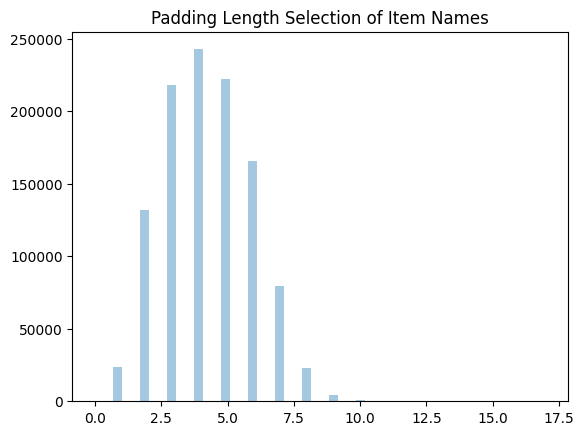

In [ ]:
select_padding(train_name, tokenizer_name, 'Item Names', 10)

Total number of words in the document are  138020
0.5882717975791011  % of rows have sentence length >  125 



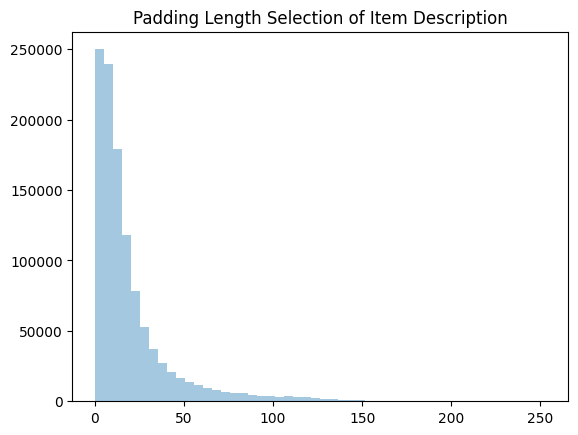

In [ ]:
select_padding(train_desc, tokenizer_desc, 'Item Description', 125)

In [ ]:
# selecting these values from the graph above
NAME_LENGTH = 10
DESC_LENGTH = 125

In [ ]:
train_name_pad,test_name_pad = text_padding(train_name,test_name,NAME_LENGTH)
train_desc_pad,test_desc_pad = text_padding(train_desc,test_desc,DESC_LENGTH)

## 11.4. Encoding Categorical Features - Cat, Brand, Ship, Item - Cond

In [ ]:
'''
This Code performs Categorical Feature to Numeric
Encodings based on Ranks by Word Frequency in the Vocabulary,
takes train, test as input and returns encoded train, test data
and the vocab size as output
'''

def self_token(column):
  unique = list(set(column))
  total = list(column)
  size = len(unique)
  count = []

  for category in unique:
    count.append([total.count(category), category])
  count.sort()

  rank = {}
  for i in range(1, len(count) + 1):
    rank.update({count[i-1][1] : i})
  return (rank, unique, size)

def category_encoder(train, test):
  cat_rank, unique, size = self_token(train)
  encoded_train = []
  encoded_test = []

  for category in train:
    encoded_train.append(cat_rank[category])

  for category in test:
    if category in unique:
      encoded_test.append(cat_rank[category])
    else:
      encoded_test.append(0)

  encoded_train = np.asarray(encoded_train)
  encoded_test = np.asarray(encoded_test)
  return encoded_train, encoded_test, size


In [ ]:
train_ship,test_ship,ship_size = category_encoder(df_train_model['shipping'].astype('category'),
                                                  df_test_model['shipping'].astype('category'))

train_ici,test_ici,ici_size = category_encoder(df_train_model['item_condition_id'].astype('category'),
                                                  df_test_model['item_condition_id'].astype('category'))

train_brand,test_brand,brand_size = category_encoder(df_train_model['brand_name'].fillna('missing').astype('category'),
                                                  df_test_model['brand_name'].fillna('missing').astype('category'))

train_cat,test_cat,cat_size = category_encoder(df_train_model['category_name'].fillna('missing').astype('category'),
                                                  df_test_model['category_name'].fillna('missing').astype('category'))

## 11.5. Creating Embedding Layers

In [ ]:
'''
This Code creates an embedding matrix using Glove 300-D
vector representation of words.
It Creates an Embedding Matrix of
shape (vocab_size,300)
'''

import pickle

def generate_embedding_matrix(token):
    with open('/content/gdrive/MyDrive/Mercari Price Prediction/3. Modelling/final_processing/glove_vectors.pkl', 'rb') as f:
        model = pickle.load(f)  # Load the KeyedVectors model

    # Get word vocabulary using model.index_to_key (instead of keys())
    glove_words = set(model.index_to_key)

    embedding_matrix_text = np.zeros((len(token.word_index) + 1, 300))
    for word, i in tqdm_notebook(token.word_index.items()):
        if word in glove_words:
            embedding_vector = model[word]  # Access vectors using model[word]
            embedding_matrix_text[i] = embedding_vector

    return embedding_matrix_text

In [ ]:
embedding_name = generate_embedding_matrix(tokenizer_name)
embedding_desc = generate_embedding_matrix(tokenizer_desc)
print(embedding_name.shape,embedding_desc.shape)

  0%|          | 0/89565 [00:00<?, ?it/s]

  0%|          | 0/138019 [00:00<?, ?it/s]

(89566, 300) (138020, 300)


## 11.6. Numeric Features - 17 new Features generated

In [ ]:
'''
Loading the 17 features generated in the Feature Engineering section
'''

file = open('/content/gdrive/MyDrive/Mercari Price Prediction/2. Processing/storage/train_desc_feats', 'rb')
train_desc_feats = pickle.load(file)
file.close()

file = open('/content/gdrive/MyDrive/Mercari Price Prediction/2. Processing/storage/test_desc_feats', 'rb')
test_desc_feats = pickle.load(file)
file.close()

file = open('/content/gdrive/MyDrive/Mercari Price Prediction/2. Processing/storage/train_senti_names', 'rb')
train_senti_names = pickle.load(file)
file.close()
file = open('/content/gdrive/MyDrive/Mercari Price Prediction/2. Processing/storage/test_senti_names', 'rb')
test_senti_names = pickle.load(file)
file.close()

file = open('/content/gdrive/MyDrive/Mercari Price Prediction/2. Processing/storage/train_senti_desc', 'rb')
train_senti_desc = pickle.load(file)
file.close()

file = open('/content/gdrive/MyDrive/Mercari Price Prediction/2. Processing/storage/test_senti_desc', 'rb')
test_senti_desc = pickle.load(file)
file.close()
#####################################################################
file = open('/content/gdrive/MyDrive/Mercari Price Prediction/2. Processing/storage/train_cbs_feats', 'rb')
train_cbs_feats = pickle.load(file)
file.close()

file = open('/content/gdrive/MyDrive/Mercari Price Prediction/2. Processing/storage/test_cbs_feats', 'rb')
test_cbs_feats = pickle.load(file)
file.close()


In [ ]:
'''Creating Feature stack using np.hstack to pass into LSTM model'''

X_train_numerics = np.hstack((train_desc_feats,
                              np.array(train_senti_names).reshape(-1,1),
                              np.array(train_senti_desc).reshape(-1,1),
                              train_cbs_feats))
X_test_numerics = np.hstack((test_desc_feats,
                              np.array(test_senti_names).reshape(-1,1),
                              np.array(test_senti_desc).reshape(-1,1),
                              test_cbs_feats))

print(X_train_numerics.shape,'\n',X_test_numerics.shape)

(1111901, 17) 
 (370634, 17)


In [ ]:
'''Creating the Train,Test Input to pass into LSTM Input Layers as list'''

X_train = [train_name_pad,train_desc_pad,
         np.array(train_ship),np.array(train_ici),np.array(train_brand),np.array(train_cat),
         X_train_numerics]
X_test =  [test_name_pad,test_desc_pad,
         np.array(test_ship),np.array(test_ici),np.array(test_brand),np.array(test_cat),
         X_test_numerics]

y_train = np.log1p(df_train_model['price'])
y_test = np.log1p(df_test_model['price'])

In [ ]:
file = open('/content/gdrive/MyDrive/Mercari Price Prediction/3. Modelling/final_processing/lstm features/X_train', 'wb')
pickle.dump(X_train, file)
file.close()
file = open('/content/gdrive/MyDrive/Mercari Price Prediction/3. Modelling/final_processing/lstm features/X_test', 'wb')
pickle.dump(X_test, file)
file.close()

file = open('/content/gdrive/MyDrive/Mercari Price Prediction/3. Modelling/final_processing/lstm features/y_train', 'wb')
pickle.dump(y_train, file)
file.close()
file = open('/content/gdrive/MyDrive/Mercari Price Prediction/3. Modelling/final_processing/lstm features/y_test', 'wb')
pickle.dump(y_test, file)
file.close()

file = open('/content/gdrive/MyDrive/Mercari Price Prediction/3. Modelling/final_processing/lstm features/tokenizer_name', 'wb')
pickle.dump(tokenizer_name, file)
file.close()
file = open('/content/gdrive/MyDrive/Mercari Price Prediction/3. Modelling/final_processing/lstm features/tokenizer_desc', 'wb')
pickle.dump(y_test, file)
file.close()

file = open('/content/gdrive/MyDrive/Mercari Price Prediction/3. Modelling/final_processing/lstm features/embedding_name', 'wb')
pickle.dump(embedding_name, file)
file.close()
file = open('/content/gdrive/MyDrive/Mercari Price Prediction/3. Modelling/final_processing/lstm features/embedding_desc', 'wb')
pickle.dump(embedding_desc, file)
file.close()


## 11.7. Create LSTM Model

In [ ]:
'''
This Code builds the LSTM Model Architecture based on Input Data size, parameters passed
'''

def build_lstm_model(NAME_LENGTH,tokenizer_name,embedding_name,DESC_LENGTH,tokenizer_desc,embedding_desc,ship_size,ici_size,brand_size,cat_size,NUMERIC_LENGTH):

    text_input_name = Input(shape=(NAME_LENGTH,), name='TEXT_ITEM_NAME')
    x = Embedding(len(tokenizer_name.word_index) + 1, 300, weights=[embedding_name], input_length=NAME_LENGTH)(text_input_name)
    lstm_out = LSTM(100,recurrent_dropout=0.25,return_sequences=True)(x)
    flatten_1 = Flatten()(lstm_out)

    text_input_desc = Input(shape=(DESC_LENGTH,), name='TEXT_DESC_NAME')
    x = Embedding(len(tokenizer_desc.word_index) + 1, 300, weights=[embedding_desc], input_length=DESC_LENGTH)(text_input_desc)
    lstm_out = LSTM(100,recurrent_dropout=0.25,return_sequences=True)(x)
    flatten_2 = Flatten()(lstm_out)

    shipping_feat = Input(shape=(1,), name='SHIPPING')
    x = Embedding(ship_size + 1, 10, input_length=1)(shipping_feat)
    flatten_3 = Flatten()(x)

    item_cond_feat = Input(shape=(1,), name='ITEM_CONDITION')
    x = Embedding(ici_size + 1, 10, input_length=1)(item_cond_feat)
    flatten_4 = Flatten()(x)

    brand_feat = Input(shape=(1,), name='BRAND')
    x = Embedding(brand_size + 1, 10, input_length=1)(brand_feat)
    flatten_5 = Flatten()(x)

    cat_feat = Input(shape=(1,), name='CATEGORY')
    x = Embedding(cat_size + 1, 10, input_length=1)(cat_feat)
    flatten_6 = Flatten()(x)

    numeric_feat = Input(shape=(NUMERIC_LENGTH,), name='NUMERIC_FEATURES')
    dense_1 = Dense(1, activation='relu',kernel_initializer="he_normal",kernel_regularizer=tensorflow.keras.regularizers.l2(0.001))(numeric_feat)

    x = concatenate([flatten_1,flatten_2,flatten_3,flatten_4,flatten_5,flatten_6,dense_1])

    x = Dense(100, activation='relu',kernel_initializer="he_normal",kernel_regularizer=tensorflow.keras.regularizers.l2(0.001))(x)
    x = Dropout(0.2)(x)
    x = BatchNormalization()(x)
    x = Dense(50, activation='relu',kernel_initializer="he_normal",kernel_regularizer=tensorflow.keras.regularizers.l2(0.001))(x)
    x = Dropout(0.3)(x)
    x = BatchNormalization()(x)

    x = Dense(10, activation='relu',kernel_initializer="he_normal",kernel_regularizer=tensorflow.keras.regularizers.l2(0.001))(x)
    final_output = Dense(1, activation='linear')(x)

    model = Model(inputs=[text_input_name,text_input_desc,
                          shipping_feat,item_cond_feat,brand_feat,cat_feat,
                          numeric_feat],
                  outputs=[final_output])
    return model

In [ ]:

'''Summarizing the Model Built'''

baseline_lstm_model = build_lstm_model(NAME_LENGTH,tokenizer_name,embedding_name,
                                       DESC_LENGTH,tokenizer_desc,embedding_desc,
                                       ship_size,ici_size,brand_size,cat_size,X_train_numerics.shape[1])
baseline_lstm_model.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 TEXT_ITEM_NAME (InputLayer  [(None, 10)]                 0         []                            
 )                                                                                                
                                                                                                  
 TEXT_DESC_NAME (InputLayer  [(None, 125)]                0         []                            
 )                                                                                                
                                                                                                  
 embedding (Embedding)       (None, 10, 300)              2686980   ['TEXT_ITEM_NAME[0][0]']      
                                                          0                                   

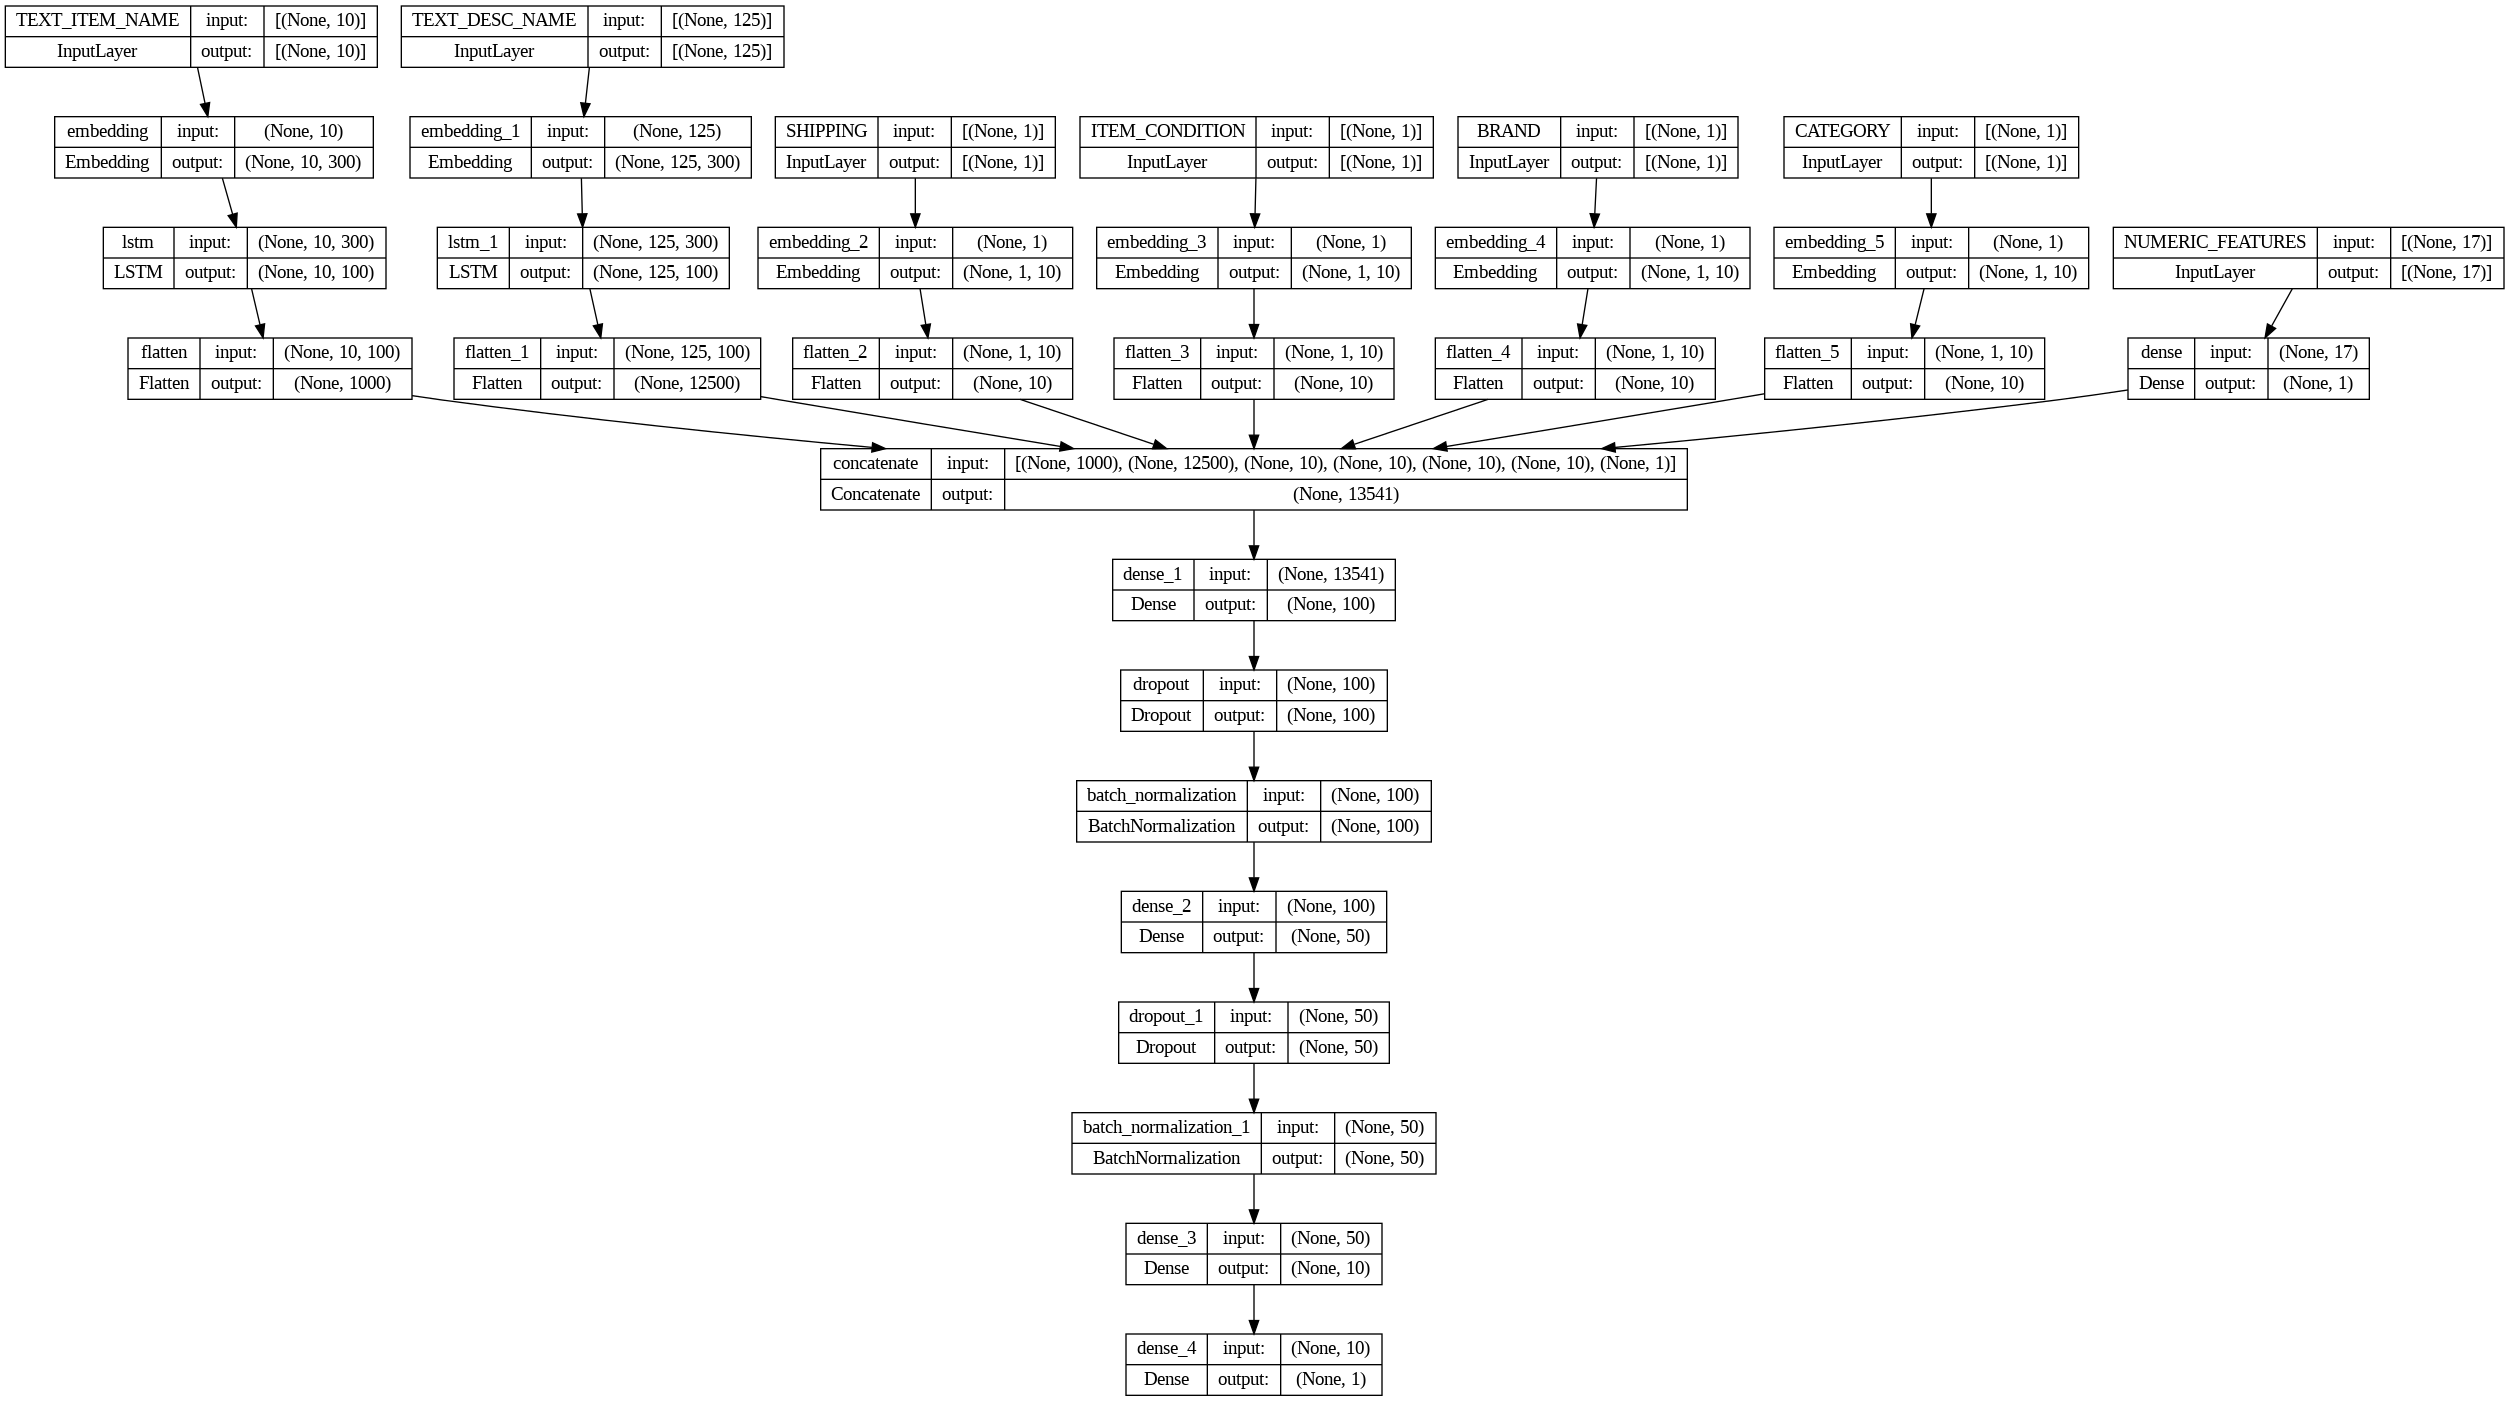

In [ ]:
'''Graphical Visualization of LSTM Model'''

plot_model(baseline_lstm_model, to_file='baseline_lstm_model.png', show_shapes=True, show_layer_names=True)
Image(filename='baseline_lstm_model.png')

## 11.8. Train Model

In [ ]:
# Load the TensorBoard notebook extension
%load_ext tensorboard

In [30]:

'''Training LSTM Model for 100 epochs using Adam Optimizer with Batch Size = 4096'''

baseline_lstm_model.compile(optimizer='adam', loss='mean_squared_error')
filepath = "lstm_model/baseline_lstm_model_epochs:{epoch:03d}-val_loss:{val_loss:.3f}.hdf5"

checkpoint = ModelCheckpoint(filepath,monitor="val_loss",mode="min",save_best_only = True,verbose = 1)
tensorboard = tf.keras.callbacks.TensorBoard(log_dir='/content/gdrive/My Drive/Mercari2/log_baseline_lstm_model')
callbacks_list = [checkpoint,tensorboard]

history_baseline_lstm_model = baseline_lstm_model.fit(X_train,y_train,
                                                      batch_size=4096,
                                                      epochs=15,
                                                      verbose=1,
                                                      validation_data=(X_test, y_test),
                                                      callbacks = callbacks_list)

Epoch 1/15
272/272 [==============================] - ETA: 0s - loss: 2.3831
Epoch 1: val_loss improved from inf to 0.70982, saving model to lstm_model/baseline_lstm_model_epochs:001-val_loss:0.710.hdf5
272/272 [==============================] - 1862s 7s/step - loss: 2.3831 - val_loss: 0.7098
Epoch 2/15
272/272 [==============================] - ETA: 0s - loss: 0.5469
Epoch 2: val_loss improved from 0.70982 to 0.45911, saving model to lstm_model/baseline_lstm_model_epochs:002-val_loss:0.459.hdf5
272/272 [==============================] - 1759s 6s/step - loss: 0.5469 - val_loss: 0.4591
Epoch 3/15
272/272 [==============================] - ETA: 0s - loss: 0.4041
Epoch 3: val_loss improved from 0.45911 to 0.36832, saving model to lstm_model/baseline_lstm_model_epochs:003-val_loss:0.368.hdf5
272/272 [==============================] - 1744s 6s/step - loss: 0.4041 - val_loss: 0.3683
Epoch 4/15
272/272 [==============================] - ETA: 0s - loss: 0.3328
Epoch 4: val_loss improved from 0

## 11.9 Test Model

In [31]:
def rmsle_score(y, y_pred):
    assert len(y) == len(y_pred)
    to_sum = [(math.log(y_pred[i] + 1) - math.log(y[i] + 1)) ** 2.0 for i,pred in enumerate(y_pred)]
    return (sum(to_sum) * (1.0/len(y))) ** 0.5

def rmsle_K(y, y0):
    return K.sqrt(K.mean(K.square(tf.log1p(y) - tf.log1p(y0))))

In [33]:
best_model = load_model('/content/gdrive/MyDrive/Mercari Price Prediction/lstm_model/baseline_lstm_model_epochs:011-val_loss:0.256.hdf5',custom_objects={"rmsle_K":rmsle_K})

preds = np.expm1(best_model.predict(X_test,batch_size = 4096,verbose = 1))
print('RMSLE of Test set is ',rmsle_score(np.expm1(y_test).values , preds))

91/91 [==============================] - 153s 2s/step
RMSLE of Test set is  0.4799348605343345


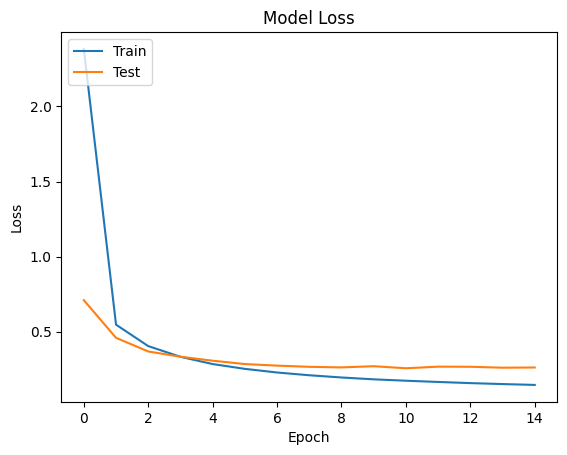

In [34]:
plt.plot(history_baseline_lstm_model.history['loss'])
plt.plot(history_baseline_lstm_model.history['val_loss'])
plt.title('Model Loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Test'], loc='upper left')
plt.show()